# objective :
<br>1. Applying naive bayes to classify the amazon food reviews.
<br>2. Check for different types of scoring merrics
<br>3. Getting the important features.

In [1]:
#importing all module
import sqlite3 as s
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix


C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con=s.connect("database.sqlite")
con

In [3]:
data=pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3",con)
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#function to change the score to positive/negative
def change(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

In [5]:
a_s=data.Score
a_s=a_s.map(change)
data.Score=a_s
data.Score.head(5)

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object

# Data cleaning

The data needs to get clean as it may have some unwanted things such as duplicates.

In [6]:
#sorting the values by product ids
data=data.sort_values("ProductId")

In [7]:
#removing the duplicates from the data
final_data=data.drop_duplicates(subset={"UserId","Text","ProfileName","Time"},keep="first",inplace=False)

In [8]:
print(final_data.shape)
print(final_data.Score.value_counts())

(364173, 10)
positive    307063
negative     57110
Name: Score, dtype: int64


In [9]:
p_data=final_data[final_data.Score=="positive"]
n_data=final_data[final_data.Score=="negative"]

In [10]:
#randomly selecting points
#p_data=p_data.sample(34000)
#n_data=n_data.sample(6000)

In [11]:
print(p_data.shape,n_data.shape)

(307063, 10) (57110, 10)


In [12]:
d=pd.concat((p_data,n_data))


In [13]:
print(d.shape)

(364173, 10)


In [14]:
#sorting according to time stamp
d=d.sort_values('Time')


In [15]:
print(d.Score.value_counts())

positive    307063
negative     57110
Name: Score, dtype: int64


# Data preprocessing

The data should be preprocessed after cleaning it

In [16]:
import string 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [17]:
#stopwords
stop_words=set(stopwords.words("english"))
#initializing snowball stemmer
sno=SnowballStemmer("english")

In [18]:
#function to remove html tags
def cleanhtml(s):
    cleanr=re.compile("<.*?>")
    cleant=re.sub(cleanr," ",s)
    return cleant

In [19]:
#funtion to remove punctuation and special character
def cleanpunc(s): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',s)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [20]:
i=0
final=[]

for s in d.Text.values:
    f=[]
    c=cleanhtml(s)
    for w in cleanpunc(c).split():
        if w.isalpha() and len(w)>2:
            if w not in stop_words:
                sne=(sno.stem(w.lower())).encode('utf-8')
                f.append(sne)
               
            else:
                continue
        else:
            continue
    te=b" ".join(f)
    final.append(te)
    i+=1

In [21]:
#adding the preprocessed data into another column
d["cleaned"]=final

In [22]:
#checking if new column is added
d.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'cleaned'],
      dtype='object')

In [23]:
import sqlite3
conn=sqlite3.connect("future.sqlite")
c=conn.cursor()
conn.text_factory=str
d.to_sql('Reviews',conn,if_exists='replace',index=True)

In [24]:
#replacing positive and negative with 1,0 to make it work for different metrics
d=d.replace(['positive','negative'],[1,0])
d.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel f...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'this one movi that should your movi collect ...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli after hour tra...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'what happen say name three time michael keat...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...


In [25]:
#importing the needed module
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Lets create functions for finding best parameter.

In [26]:
#function for multinomial naive bayes
def main(h,j,k,l):
    #gridsearchcv
  
    #params we need to try on classifier
    nb = MultinomialNB()
    param_grid = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100]} 
    #For time based splitting
    t = TimeSeriesSplit(n_splits=5) 
    
    gsv = GridSearchCV(nb,param_grid,cv=t,n_jobs=-1,scoring='f1',refit=True)
    gsv.fit(h,j)
    print("Best HyperParameter: ",gsv.best_params_)
    #assinging best alpha to optimal
    optimal=gsv.best_params_['alpha']
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    print("best estimator: ",gsv.estimator)
    nb_optimal=MultinomialNB(alpha=optimal)
    nb_optimal.fit(h,j)
    pred=nb_optimal.predict(k)

    #accuracy
    
    acc=accuracy_score(l,pred)*100
    print("\nthe accuracy is %.2f%%"%acc)
    
    df_cm=pd.DataFrame(confusion_matrix(l,pred))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,annot=True,fmt="d")
    
    re=recall_score(l,pred,) * 100
    print("\nthe recall is %.2f%%"%re)
    
    pre=precision_score(l,pred) * 100
    print("the precision is %.2f%%"%pre)
    
    f1=f1_score(l,pred) * 100
    print("the f1 score is %.2f%%"%f1)
   
    
 
    
   
    
    

# Bag of words

In [28]:
x_1, x_test, y_1, y_test = train_test_split(d.cleaned.values, d.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [29]:
print(x_1.shape,x_test.shape,y_1.shape,y_test.shape)

(254921,) (109252,) (254921,) (109252,)


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

In [31]:
#bigrams
count_vect=CountVectorizer(ngram_range=(1,2))

In [32]:
#transforming the data
bdata=count_vect.fit_transform(x_1)
test_data=count_vect.transform(x_test)
print(bdata.shape,y_1.shape,test_data.shape,y_test.shape)

(254921, 2351349) (254921,) (109252, 2351349) (109252,)


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 93.70%
best estimator:  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

the accuracy is 88.85%

the recall is 98.24%
the precision is 89.32%
the f1 score is 93.57%
Wall time: 35 s


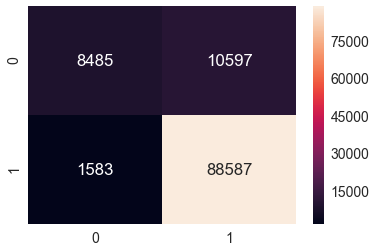

In [33]:
%%time
main(bdata,y_1,test_data,y_test)

# Feature importance

In [34]:
#getting all feature names
all_feat = count_vect.get_feature_names()
#model with optimal hyperparameter
clf=MultinomialNB(alpha=0.001)
clf.fit(bdata,y_1)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [81]:
#probability of class given feature
log_probabilities=np.exp(clf.feature_log_prob_)

In [101]:
#dataframe for negative probabilities
negative_dataframe=pd.DataFrame({"word":all_feat,"negative_proba":log_probabilities[0]})
negative_dataframe.head(4)

,word,negative_proba
0,aa,3.087364e-10
1,aa pleas,3.087364e-10
2,aa state,3.087364e-10
3,aaa,3.090451e-07


In [103]:
#sorting in descending order
negative_dataframe=negative_dataframe.sort_values(by="negative_proba",ascending=False)
negative_dataframe.head(4)

,word,negative_proba
2028406,tast,0.007193
1159383,like,0.006632
2063012,the,0.005681
1587721,product,0.005608


In [105]:
#dataframe for positive probabilites
positive_dataframe=pd.DataFrame({"word":all_feat,"positive_proba":log_probabilities[1]})
positive_dataframe.head(4)

,word,positive_proba
0,aa,1.183994e-07
1,aa pleas,5.922928e-08
2,aa state,5.922928e-08
3,aaa,1.301802e-06


In [107]:
#sorting in descending order
positive_dataframe=positive_dataframe.sort_values(by="positive_proba",ascending=False)
positive_dataframe.head(4)

,word,positive_proba
1159383,like,0.005710
2028406,tast,0.005321
2063012,the,0.004941
881139,good,0.004649


Text(0.5,1,'important features in Positive reviews')

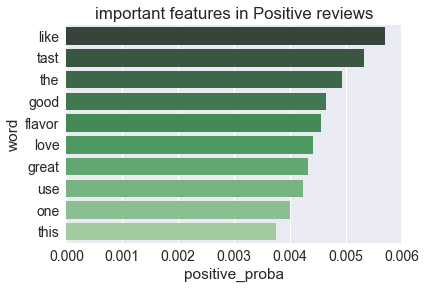

In [108]:
#barplot for positive feature importance
sns.barplot(y='word', x='positive_proba', data=positive_dataframe.head(10), palette="Greens_d").set_title('important features in Positive reviews')


Text(0.5,1,'important features in negative reviews')

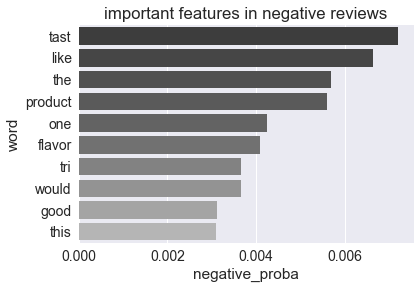

In [109]:
#barplot for negative feature importance
sns.barplot(y='word', x='negative_proba', data=negative_dataframe.head(10), palette="Greys_d").set_title('important features in negative reviews')


In [115]:
summary=pd.DataFrame({"accuracy":"88.85%","recall":"98.24%","precision":"89.32%","f1":"93.57%"},index=["score"])
summary=summary.T
summary

,score
accuracy,88.85%
recall,98.24%
precision,89.32%
f1,93.57%


# Tfidf

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [117]:
x_1, x_test, y_1, y_test = train_test_split(d.cleaned.values, d.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [118]:
#bigrams
tfidf=TfidfVectorizer(ngram_range=(1,2))

In [119]:
#transforming the data
tdata=tfidf.fit_transform(x_1)
test_data=tfidf.transform(x_test)
print(tdata.shape,test_data.shape)

(254921, 2351349) (109252, 2351349)


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 93.50%
best estimator:  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

the accuracy is 87.92%

the recall is 99.14%
the precision is 87.80%
the f1 score is 93.12%
Wall time: 32 s


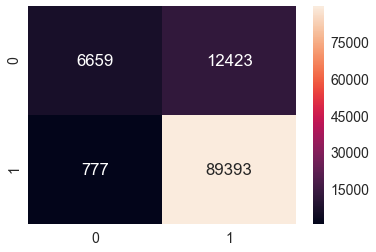

In [120]:
%%time
main(tdata,y_1,test_data,y_test)

In [121]:
#getting all feature names
all_feat = tfidf.get_feature_names()
#model with optimal hyperparameter
clf=MultinomialNB(alpha=0.001)
clf.fit(bdata,y_1)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [122]:
#probability of class given feature
log_probabilities=np.exp(clf.feature_log_prob_)

In [123]:
#dataframe for negative probabilities
negative_dataframe=pd.DataFrame({"word":all_feat,"negative_proba":log_probabilities[0]})
negative_dataframe.head(4)

,word,negative_proba
0,aa,3.087364e-10
1,aa pleas,3.087364e-10
2,aa state,3.087364e-10
3,aaa,3.090451e-07


In [124]:
#sorting in descending order
negative_dataframe=negative_dataframe.sort_values(by="negative_proba",ascending=False)
negative_dataframe.head(4)

,word,negative_proba
2028406,tast,0.007193
1159383,like,0.006632
2063012,the,0.005681
1587721,product,0.005608


In [125]:
#dataframe for positive probabilites
positive_dataframe=pd.DataFrame({"word":all_feat,"positive_proba":log_probabilities[1]})
positive_dataframe.head(4)

,word,positive_proba
0,aa,1.183994e-07
1,aa pleas,5.922928e-08
2,aa state,5.922928e-08
3,aaa,1.301802e-06


In [126]:
#sorting in descending order
positive_dataframe=positive_dataframe.sort_values(by="positive_proba",ascending=False)
positive_dataframe.head(4)

,word,positive_proba
1159383,like,0.005710
2028406,tast,0.005321
2063012,the,0.004941
881139,good,0.004649


Text(0.5,1,'important features in Positive reviews')

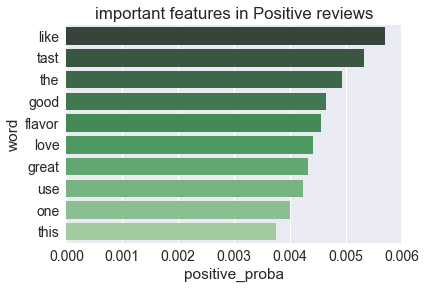

In [127]:
#barplot for positive feature importance
sns.barplot(y='word', x='positive_proba', data=positive_dataframe.head(10), palette="Greens_d").set_title('important features in Positive reviews')


Text(0.5,1,'important features in negative reviews')

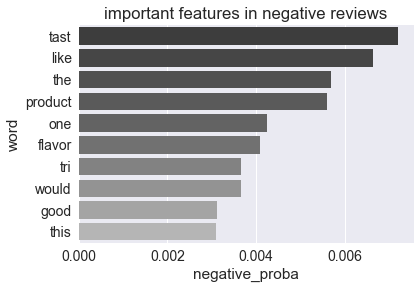

In [128]:
#barplot for negative feature importance
sns.barplot(y='word', x='negative_proba', data=negative_dataframe.head(10), palette="Greys_d").set_title('important features in negative reviews')


In [131]:
summary=pd.DataFrame({"accuracy":"87.92%","recall":"99.14%","precision":"87.80%","f1":"93.12%"},index=["score"])
summary=summary.T
summary

,score
accuracy,87.92%
recall,99.14%
precision,87.80%
f1,93.12%


Conclusion :<br>
1.naive bayes works well ,when features are independent. That is why we have not done word2vec as feature are highly dependent.
<br>
2.time complexity of naive bayes is very less.(theortically o(n*d) n=number of points,d=no of features)<br>
3.accuracy is not a good parameter to use in naive bayes

Both the above models are performing good as metrics have a good value.